##### Preamble/Imports

In [1]:
import matplotlib
matplotlib.use( "agg" )
%pylab inline

import plt_fmt

from numba import jit

Populating the interactive namespace from numpy and matplotlib


# Three-dimensional radial equation

In [2]:
# assume we're sticking within the first spherical harmonic, which is a constant

def smoothstep(x,center=1.0,sharpness=1.0):
    return 1-1/(1+exp(-x+center))**sharpness

# @jit
def lap2d(npts):
    """
    Build a central-difference laplace operator. Use a higher-order forward difference
    operator at the edges
    http://en.wikipedia.org/wiki/Finite_difference_coefficient
    """
    op = zeros([npts, npts])
    a = -2*ones((1, npts))[0]
    b = ones((1, npts-1))[0]
    op = diag(a, 0) + np.diag(b, -1) + np.diag(b, 1)
    op[0,1] = 2
    
    op[0,0] = 2
    op[0,1] = 5
    op[0,2] = 4
    op[0,3] = 1
    
    
    op[-1,-2] = 2
    
    
    return op

# @jit
def grad1D(npts):
    """
    Build a central-difference derivative operator. Use a higher-order forward difference
    operator at the edges
    http://en.wikipedia.org/wiki/Finite_difference_coefficient
    """
    op = zeros([npts, npts])
    a = zeros((1, npts))[0]
    b = .5*ones((1, npts-1))[0]
    op = diag(a, 0) + np.diag(b, -1) + np.diag(b, 1)
    
    op[0,0] = 0.
    op[0,1] = 1.
    
    op[0,0] = -1.5
    op[0,1] = 2.0
    op[0,2] = -.5
    
    op[-1,-1] = 1.
    op[-1,-2] = 0.
    return op

# @jit
def jacob(timepoint, yvals, settings_and_params):
    """
    Operator form of a system of coupled differential equations in one variable
    """
    
    settings, params = settings_and_params
    
    allspace = settings['space']
    dx = allspace[2]-allspace[1]
    
    WELL_DIAM = params['WELL_DIAM']
    POT_DIAM = params['POT_DIAM']
    KAPPA = params['KAPPA']
    DCOEFF = params['DCOEFF']
    ALPHA = params['ALPHA']
    
    DCOEFF = ALPHA*(timepoint**(ALPHA-1))*DCOEFF
    
    # remove this and change allspace
    a = POT_DIAM

    L = len(space)
    
    # second derivative step
    lap = lap2d(L)/dx**2
    jac = lap
    
    
    # first derivative steps
    drv = grad1D(L)/dx
    jac += (4*drv/allspace) - (3/(4*a**2))*allspace*drv
    
    
    # other steps
    iden = identity(L)
    jac += (1/(8*a**4))*(allspace**2)*iden
    jac += -(1/a**2)*iden
    # assume \ell = 0
    jac += (2/(allspace**2))*iden
    
    
    # now multiply by diffusion coefficient and all that
    jac = -DCOEFF*jac
    
    # now implement reaction step
    drain_window = double(allspace < WELL_DIAM)
    
    allinds = linspace(0,len(allspace),len(allspace))
    drain_window = smoothstep(allinds,center = sum(drain_window),sharpness=3)

    jac += -KAPPA*drain_window*iden
    
    
#     # now implement boundary conditions
#     jac[0,:] = jac[1,:]
#     jac[-1,:] = jac[-2,:]
    
    return jac


def nxt_step(yvals, timepoint, dt, settings, params):
    """
    Return a space-discretized approximation of the differential equation
    at the given timepoint. Our equation happens to be linear, and so the next
    step is given by a simple dot product with the relevant operator
    """
    jac = jacob(timepoint, yvals, [settings, params])
    nxt_vals = jac.dot(yvals)
    return nxt_vals

def rk4_mesh(yinit, ynxt, settings, params):
    """
    ynxt : function
        The function that computes the next step in the forward march
    
    dt : double
        The spatial step
        
    dx : double
        The time step size
        
    use_crank : boolean
        Whether to use Crank-Nicolson forward marching, in which the next timestep
        is determined by equal weights of the previous two timesteps. If not, the
        integrator uses standard Forward Euler
        
    settings : dict
        A dictionary containing all the necessary steps and 
        objects for the integration
        
    params : dict
        A dictionary containing all the necessary parameters for the 
        differential equation system.
        
    """
    use_crank = True
    
    space = settings['space']
    times = settings['times']
    dt = times[2] - times[1]
    
    solmesh = zeros([len(yinit), len(times)])
    solmesh[:,0] = yinit
    tL = len(solmesh[0,:])
    for tind, time in enumerate(times):
        if tind > 0 and tind < tL:
            
            if use_crank == False:
                ind_list = [1]
                wgt = 1.0
            else:
                ind_list = [1,2]
                wgt = .5
            
            solmesh[:,tind] = solmesh[:,tind-1]
            for ii in ind_list:
                k1 = ynxt( solmesh[:,tind-ii], time, dt, settings, params)          
                k2 = ynxt( solmesh[:,tind-ii]+ 0.5*k1, time + 0.5*dt, dt, settings, params)
                k3 = ynxt( solmesh[:,tind-ii]+ 0.5*k2, time + 0.5*dt, dt, settings, params)
                k4 = ynxt( solmesh[:,tind-ii]+ k3, time+dt, dt, settings, params)
                solmesh[:,tind] += wgt*dt*(k1 + 2.0*(k2 + k3) + k4)/6.0
    
    # get gaussian part
    gausspart = tile(exp(-space**2/(4*params['POT_DIAM']**2)),(tL,1)).T
    solmesh = solmesh*gausspart
    
    # now convert to pdf
    radpart = tile(4*pi*(space**2),(tL,1)).T
    solmesh = radpart*solmesh
    return solmesh
    
def euler_mesh(yinit, ynxt, settings, params):
    """
    ynxt : function
        The function that returns the discrete derivative at a given timepoint
    
    dt : double
        The spatial step
        
    dx : double
        The time step size
    """
    
    space = settings['space']
    times = settings['times']
    dt = times[2] - times[1]

    solmesh = zeros([len(yinit), len(times)])
    solmesh[:,0] = yinit
    tL = len(solmesh[0,:])
    for tind, time in enumerate(times):
        if tind > 0 and tind < tL:
            solmesh[:,tind] = solmesh[:,tind-1] + dt*ynxt( solmesh[:,tind-1], time, dt, settings, params)
    
    # get gaussian part
    gausspart = tile(exp(-space**2/(4*params['POT_DIAM']**2)),(tL,1)).T
    solmesh = solmesh*gausspart
    
    # now convert to pdf
    radpart = tile(4*pi*(space**2),(tL,1)).T
    solmesh = radpart*solmesh
    return solmesh

In [3]:
# RUN INTEGRATION

## pick parameter values
params = dict()
# width of reactive well
params['WELL_DIAM'] = .2
# width of overall potential well. smaller this is, the stronger the forcing
params['POT_DIAM'] = .05
params['KAPPA'] = 4e-1
params['DCOEFF'] = 1e-4
# alpha less than one
params['ALPHA']= 1.0

## set integrator settings
settings = dict()

space_pts = 25
ACTUAL_LENGTH = .5
dx = ACTUAL_LENGTH/space_pts
space = linspace(0.0, ACTUAL_LENGTH, space_pts)
space = space+dx

time_pts = 1e5
start_time = 0.0
stop_time = 17.0
dt = (stop_time-start_time)/time_pts
times = linspace(start_time, stop_time, time_pts)
times = times + dt

# initial conditions
y0 = ones(space_pts)

# settings['dx'] = dx
settings['space'] = space
settings['times'] = times

sol = rk4_mesh(y0, nxt_step, settings, params)

print ("Done")

KeyboardInterrupt: 

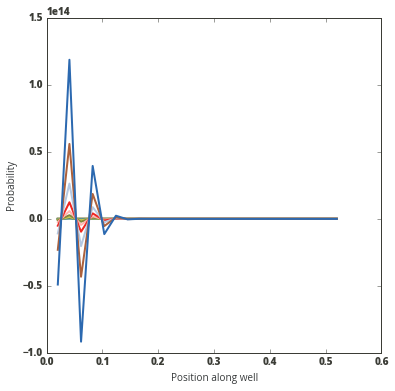

In [135]:
# plot space-time concentration
# figure()
# imshow(sol, aspect='auto')

# plot time slices
figure()
solrange = len(sol[0,:])
num_slices = 50
hold(True)
slice_range = floor(solrange/num_slices)
for ii in range(num_slices):
    plot(space, sol[:,ii*slice_range])
plot(space, sol[:,-1])
# ylim([0,.05])
rcParams['font.family']='Open Sans'
xlabel("Position along well")
ylabel("Probability")
# 'alpha_' + str(params['ALPHA']) + '__diff_' + str(params['DCOEFF'])
# savefig('harmonic_alpha_1__a_p2__V_p4.pdf')


# figure()
# total_conc = sum(sol, axis = 0)
# plot(times,total_conc[:-1])
# ylabel("Total count")
# xlabel("time")

## Find effective drag coefficient

In [73]:
## pick parameter values
# alpha less than one
ALPHA = 1.0
DCOEFF = .2
KAPPA = 8e3
# width of overall potential well. smaller this is, the stronger the forcing
POT_DIAM = 1.0
# width of reactive well
WELL_DIAM = .15
params = (ALPHA, DCOEFF, KAPPA, POT_DIAM, WELL_DIAM)

well_diams = linspace(.001,.5,10)

allsol=list()

for diam in well_diams:
    WELL_DIAM = diam
    params = (ALPHA, DCOEFF, KAPPA, POT_DIAM, WELL_DIAM)
    allsol.append( rk4_mesh(y0, nxt_step, 0.0, actual_time, dt, [space, dx, params]) )
    print (diam)

NameError: name 'actual_time' is not defined

NameError: name 'allsol' is not defined

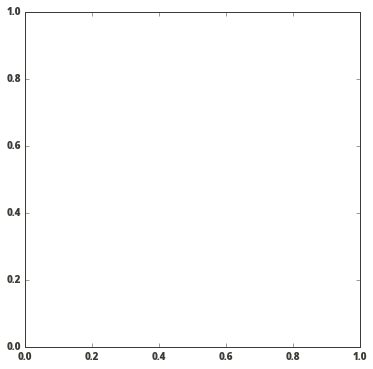

In [41]:
figure()
hold(True)
gg=list()
for sol in allsol:
    total_conc = sum(sol, axis = 0)
    gg.append(1/sum(total_conc[:-1]))
loglog(1/well_diams**2, array(gg),'.',markersize=10)
# loglog(well_diams, array(gg),'.',markersize=10)


### Use LSODA integrator

In [5]:
from scipy.integrate import ode

def nxt_step(timepoint, yvals, settings_and_params):
    settings, params = settings_and_params
    jac = jacob(timepoint, yvals, [settings, params])
    nxt_vals = jac.dot(yvals)
    return nxt_vals

## pick parameter values
params = dict()
# width of reactive well
params['WELL_DIAM'] = .05
# width of overall potential well. smaller this is, the stronger the forcing
params['POT_DIAM'] = .05
params['KAPPA'] = 4e-1
params['DCOEFF'] = 1e-6
# alpha less than one
params['ALPHA']= .5

## set integrator settings
settings = dict()

space_pts = 100
ACTUAL_LENGTH = .5
dx = ACTUAL_LENGTH/space_pts
space = linspace(0.0, ACTUAL_LENGTH, space_pts)
space = space+dx

time_pts = 1e6
start_time = 0.0
stop_time = 17.0
dt = (stop_time-start_time)/time_pts
times = linspace(start_time, stop_time, time_pts)
times = times + dt

# initial conditions
y0 = ones(space_pts)

# settings['dx'] = dx
settings['space'] = space
settings['times'] = times



r = ode(nxt_step, jacob).set_integrator('vode', method='bdf', with_jacobian=True)
r = ode(nxt_step, jacob).set_integrator('lsoda', with_jacobian=True)
# r = ode(nxt_step, jacob).set_integrator('dop853')
r.set_initial_value(y0, times[0])

r.set_f_params([settings, params])
r.set_jac_params([settings, params])

t1 = stop_time
sol = list()
while r.successful() and r.t < t1:
    r.integrate(r.t+dt)
    sol.append(r.y)

sol = array(real(sol)).T

gauss = exp(-space**2/(4*params['POT_DIAM']**2))
gauss = gauss[:, None]
sol = sol*gauss


radpart = 4*pi*(space**2)
radpart = radpart[:, None]
sol = sol*radpart

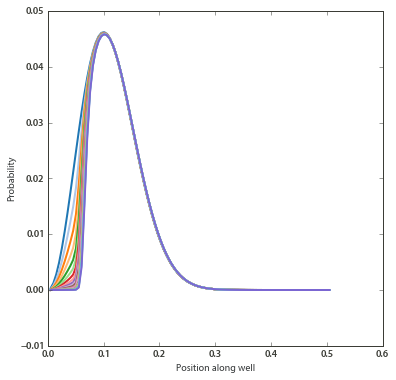

In [6]:
# plot time slices
figure()
solrange = len(sol[0,:])
num_slices = 20
hold(True)
slice_range = floor(solrange/num_slices)
for ii in range(num_slices):
    plot(space, sol[:,ii*slice_range])
plot(space, sol[:,-1])
# ylim([0,.05])
rcParams['font.family']='Open Sans'
xlabel("Position along well")
ylabel("Probability")
namestr = 'alpha_' + str(params['ALPHA']) + '__diffu_' + str(params['DCOEFF'])+'__kappa_' +\
str(params['KAPPA'])+'__reacdiam_' +str(params['WELL_DIAM'])+'__potdiam_' + str(params['POT_DIAM'])
# savefig(namestr+'.pdf')


# figure()
# figure() 
# total_conc = sum(sol, axis = 0)
# plot(times,total_conc[:-1])
# ylabel("Total count")
# xlabel("time")

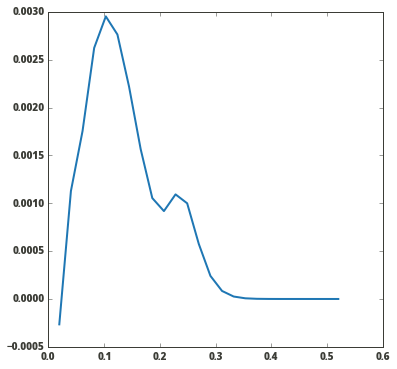

In [153]:
plot(space, sol[:,400000])

In [7]:
## pick parameter values

well_diams = linspace(.001,.3,20)

allsol=list()
for diam in well_diams:
    params['POT_DIAM'] = diam
    
    # have to re-intialize because r is a generator expression
    r = ode(nxt_step, jacob).set_integrator('lsoda', with_jacobian=True)
    r.set_initial_value(y0, times[0])
    r.set_f_params([settings, params])
    r.set_jac_params([settings, params])
    t1 = stop_time
    
    sol = list()
    while r.successful() and r.t < t1:
        r.integrate(r.t+dt)
        sol.append(r.y)
    sol = array(real(sol)).T

    gauss = exp(-space**2/(4*params['POT_DIAM']**2))
    gauss = gauss[:, None]
    sol = sol*gauss

    radpart = 4*pi*(space**2)
    radpart = radpart[:, None]
    sol = sol*radpart
    
    
    allsol.append( sol )
    
    
    print (diam)

0.001
0.0167368421053
0.0324736842105
0.0482105263158
0.0639473684211
0.0796842105263
0.0954210526316
0.111157894737
0.126894736842
0.142631578947
0.158368421053
0.174105263158
0.189842105263
0.205578947368
0.221315789474
0.237052631579
0.252789473684
0.268526315789
0.284263157895
0.3


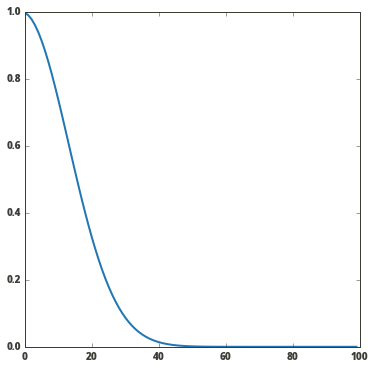

In [56]:
# Check to make sure that size of gaussian is reasonable 
# given the size of the simulation box
plot(gauss)

In [ ]:
import pickle
namestr = 'MANYSOL__alpha_' + str(params['ALPHA']) + '__diffu_' + str(params['DCOEFF'])+'__kappa_' +\
str(params['KAPPA'])+'__reacdiam_'+ str(params['POT_DIAM'])

thefile = open(namestr+'.pkl', 'w')
pickle.dump(allsol, thefile)

In [ ]:
import cPickle as pickle
allsol = pickle.load(namestr+'.pkl')

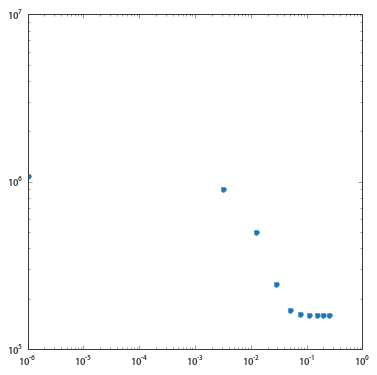

In [22]:
figure()
hold(True)
gg=list()
for sol in allsol:
    total_conc = sum(sol, axis = 0)
    gg.append(sum(total_conc[:-1]))
loglog(well_diams**2, array(gg),'.',markersize=10)
# loglog(well_diams, array(gg),'.',markersize=10)

# Calculate absorption probability

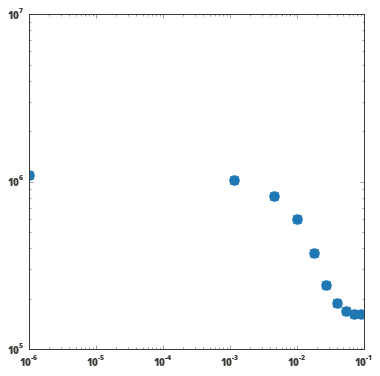

In [59]:
figure()
hold(True)

gg=list()
for sol in allsol:
    total_conc = sum(sol, axis = 0)
    gg.append(sum(total_conc[:-1]))
loglog(well_diams**2, array(gg),'.',markersize=20)

# Calculate first passage time distribution

RuntimeError: TrueType font is missing table

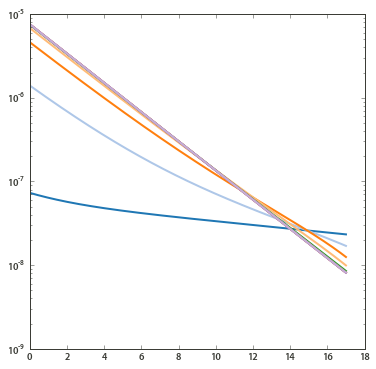

In [23]:
def make_fht(times, sol):
    '''
    Do I need to weight the summation by the reaction kernel?
    '''
    fht = (-diff(sum(sol, axis = 0)))
    return fht

figure()
hold(True)
all_tau=list()
for spec_sol in allsol:
    fht = make_fht(times, spec_sol)
    semilogy(times[:-1],fht)

    krate = mean( diff(log(fht)) )
    krate = krate/mean( diff(times) )
    tau = -1/krate
    all_tau.append(tau)


savefig('first_hitting_times.pdf')

/Users/william/miniconda/envs/spakenv/lib/python3.4/site-packages/matplotlib/font_manager.py:1282: UserWarning: findfont: Font family ['dsfdfg'] not found. Falling back to Bitstream Vera Sans
  (prop.get_family(), self.defaultFamily[fontext]))


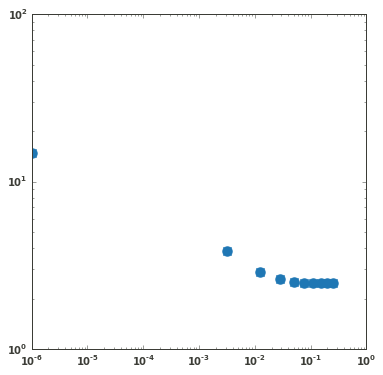

In [29]:
loglog(well_diams**2, array(all_tau),'.',markersize=20)
# savefig('timescale_v_welldiam.pdf')

# Appendix code

In [ ]:
import unittest

class IntegratorTest(unittest.TestCase):
    def test(self):
        self.assertEqual(fun(3), 4)

In [ ]:
def nxt_step(yvals, timepoint, dt, settings, params):
    
    assert dt > 0
    
    allspace = settings['space']
    dx = allspace[2]-allspace[1]
    
    WELL_DIAM = params['WELL_DIAM']
    POT_DIAM = params['POT_DIAM']
    KAPPA = params['KAPPA']
    DCOEFF = params['DCOEFF']
    ALPHA = params['ALPHA']
    
    DCOEFF = ALPHA *(timepoint**(ALPHA-1))*DCOEFF
    
    # remove this and change allspace
    a = POT_DIAM

    L = len(yvals)
        
    nxt_vals = zeros(len(yvals))
    
    # second derivative step
    lap = lap2d(L) 
    nxt_vals += (1/dx**2)*lap.dot(yvals)
    
    
    # first derivative steps
    drv = grad1D(L)
    drvvals = (1/dx)*drv.dot(yvals)
    nxt_vals += (4*drvvals)/allspace
    nxt_vals += -(3/4)*allspace*drvvals/(a**2)
    
    
    # other steps
    nxt_vals += (1/(8*a**4))*(allspace**2)*yvals
    nxt_vals += -(1/a**2)*yvals
    # assume \ell = 0
    nxt_vals += (2/(allspace**2))*yvals
    
    
    # now multiply by diffusion coefficient and all that
    nxt_vals = -DCOEFF*nxt_vals
    
    # now implement reaction step
    drain_window = double(allspace < WELL_DIAM)
    
    # smooth step
#     drain_window = 1-smoothstep(linspace(0,L,L),center=floor(WELL_DIAM/allspace[-1]),sharpness=.9)
    
    nxt_vals += -KAPPA*drain_window*yvals
    
    # now implement boundary conditions
    nxt_vals[0] = nxt_vals[1]
    nxt_vals[-1] = nxt_vals[-2]
    
    return nxt_vals